Imports & Data Preprocessing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error

path = './data/movies_dataset.csv'

df = pd.read_csv(path)

#We split the dataset intro train and test, and parameters and target
X = df.drop(columns=['Global_BoxOfficeUSD'])
y = df['Global_BoxOfficeUSD']

# Hacer el split ANTES de cualquier transformación
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test
    random_state=42,     # for replicability
    shuffle=True         
)

#We drop the columns that had a high correlation with 'Global_BoxOfficeUSD' as identified during the data cleaning
to_drop = [
    'US_BoxOfficeUSD',       
    'Opening_Day_SalesUSD',  
    'One_Week_SalesUSD'      
]
to_drop = [c for c in to_drop if c in X_train.columns]
if len(to_drop) > 0:
    X_train = X_train.drop(columns=to_drop)
else:
    print("Columns have already been dropped")

#We extract year, month and day from the release date, useful to  detect seasonal patterns
X_train['ReleaseDate'] = pd.to_datetime(X_train['ReleaseDate'], dayfirst=True, errors='coerce')
X_train['ReleaseDate_Year'] = X_train['ReleaseDate'].dt.year
X_train['ReleaseDate_Month'] = X_train['ReleaseDate'].dt.month
X_train['ReleaseDate_Day'] = X_train['ReleaseDate'].dt.day

#Numerical column scaling
cols_to_scale = [
    'BudgetUSD', 
    'NumVotesIMDb', 'NumVotesRT',
    'IMDbRating', 'RottenTomatoesScore',
    'ReleaseDate_Year', 'ReleaseDate_Month', 'ReleaseDate_Day'
]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

#We also drop some non-numerical columns that are not relevant for specific models
to_drop = [
    'MovieID',       
    'Title',  
    'Director',
    'LeadActor',
    'ReleaseYear', #numerical but duplicated, as we will convert ReleaseDate to separate year, month and day columns
    'ReleaseDate'  #already used, to get the year, month and day columns
]
to_drop = [c for c in to_drop if c in X_train_scaled.columns]
if len(to_drop) > 0:
    X_train_numerical = X_train_scaled.drop(columns=to_drop)
else:
    print("Columns have already been dropped")

#There are not too many different genres/countries, so they can be useful if we one-hot encode them
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Genre'], prefix='Genre')
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Country'], prefix='Country')

#We apply the same transformations to the test set

# ReleaseDate → year / month / day
X_test['ReleaseDate'] = pd.to_datetime(X_test['ReleaseDate'], dayfirst=True, errors='coerce')
X_test['ReleaseDate_Year'] = X_test['ReleaseDate'].dt.year
X_test['ReleaseDate_Month'] = X_test['ReleaseDate'].dt.month
X_test['ReleaseDate_Day'] = X_test['ReleaseDate'].dt.day

# Drop same correlated columns
X_test = X_test.drop(columns=to_drop, errors='ignore')

# Scaling (use transform only!)
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Drop the same non-numerical columns
X_test_numerical = X_test_scaled.drop(columns=to_drop, errors='ignore')

# One-hot encoding: ensure same columns as train
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Genre'], prefix='Genre')
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Country'], prefix='Country')

# Reindex to match train columns
X_test_numerical = X_test_numerical.reindex(columns=X_train_numerical.columns, fill_value=0)

print("Final dataset shape:", X_train_numerical.shape)
X_train_numerical.head()

Matplotlib is building the font cache; this may take a moment.


Final dataset shape: (799999, 26)


,BudgetUSD,IMDbRating,RottenTomatoesScore,NumVotesIMDb,NumVotesRT,ReleaseDate_Year,ReleaseDate_Month,ReleaseDate_Day,Genre_Action,Genre_Comedy,...,Country_Australia,Country_Canada,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,Country_South Korea,Country_UK,Country_USA
566853,-0.241545,0.675644,1.148362,-0.190588,0.638026,-0.312189,1.299563,-0.651791,False,True,...,False,False,False,False,True,False,False,False,False,False
382311,-0.047463,-0.939364,-1.068053,-0.353971,-0.200939,-0.571845,-1.312673,-0.651791,False,False,...,True,False,False,False,False,False,False,False,False,False
241519,-0.306311,-1.141241,-0.840729,-0.276840,-0.234123,0.674506,-0.151679,-0.197554,False,False,...,False,False,False,False,False,False,False,False,False,True
930120,-0.347633,0.810228,0.239064,-0.321399,-0.233175,0.622574,-0.151679,0.483803,False,False,...,False,False,False,False,False,False,False,False,False,True
911069,-0.421552,0.271892,-0.272417,-0.348078,-0.197384,0.310987,-1.602922,0.710922,True,False,...,False,False,False,False,False,False,False,False,False,True


RANSAC

In [2]:
ransac = RANSACRegressor(
  LinearRegression(),
  max_trials=100, # default value
  min_samples=0.95,
  residual_threshold=None, # default value
  random_state=123)

ransac.fit(X_train_numerical, y_train)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

In [3]:
y_pred = ransac.predict(X_test_numerical)

RANSAC - Model Evaluation

In [4]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# Adjusted R²  
n = X_test_numerical.shape[0]     
p = X_test_numerical.shape[1]     
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.4f}")

#  Mean Squared Log Error
msle = mean_squared_log_error(y_test, y_pred)
print(f"MSLE: {msle:.6f}")


MAE: 10836463.54
R²: 0.8039
Adjusted R²: 0.8039
MSLE: 0.283695


HUBBER

Computed δ (Huber threshold): 8849788.21555

----- Huber Regression Evaluation -----
MAE: 3544459.523524214
MSE: 123101950492228.61
RMSE: 11095131.83753256
R²: 0.9746977662471864


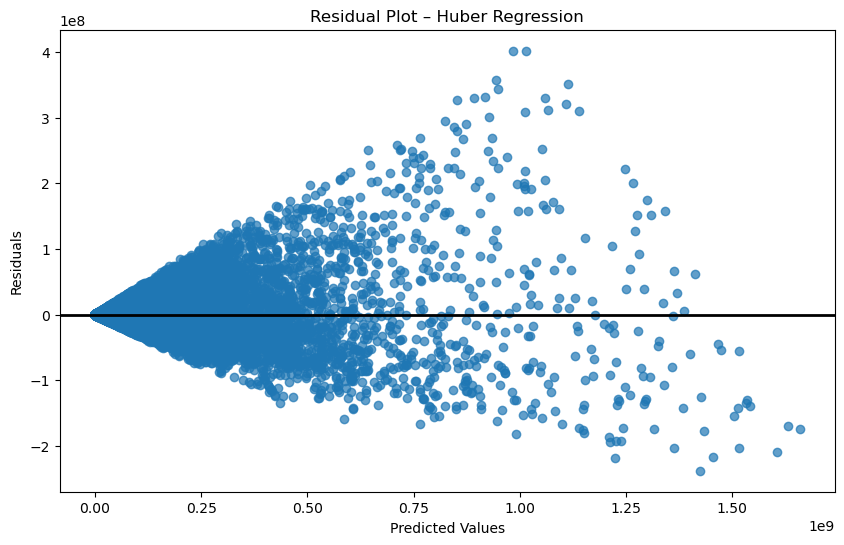

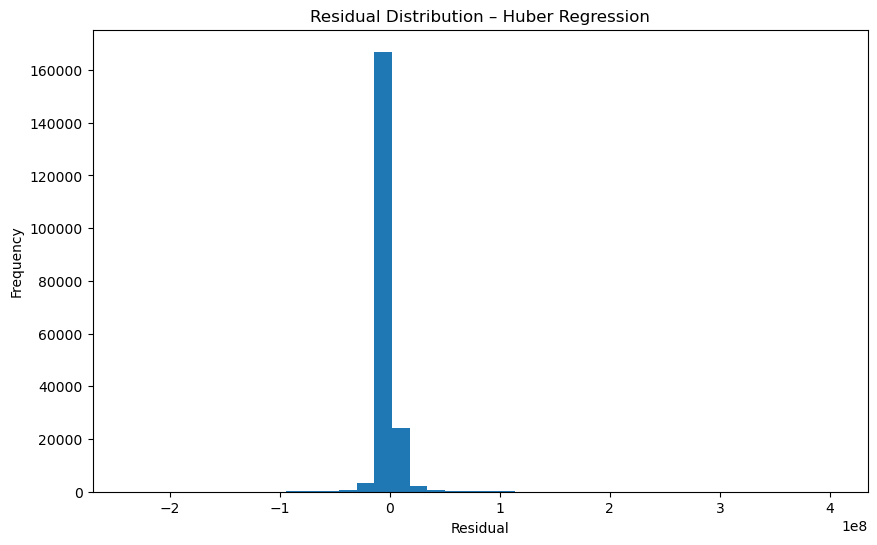


Huber Model Coefficients:
BudgetUSD: 8185503.013122851
US_BoxOfficeUSD: 56236216.70888409
Opening_Day_SalesUSD: 327937.07716974977
One_Week_SalesUSD: 4700620.094679068
IMDbRating: 34119.157928258035
RottenTomatoesScore: -38524.70013787447
NumVotesIMDb: 13608.721923007955
NumVotesRT: 10942.855178817603

Huber Intercept: 27174299.336744804


In [5]:
###############################################
# Huber Regression – Preprocessing + Modeling #
###############################################

# Select numerical features for regression (same structure as RANSAC)
numerical_features = [
    'BudgetUSD', 'US_BoxOfficeUSD', 'Opening_Day_SalesUSD',
    'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore',
    'NumVotesIMDb', 'NumVotesRT'
]

# Target variable (example: Global box office)
target_variable = 'Global_BoxOfficeUSD'

X = df[numerical_features]
y = df[target_variable]

###############################################
# 1. Train–Test Split (BEFORE transformations)
###############################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

###############################################
# 2. Preprocessing (Scaling AFTER the split)
###############################################
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit scaler ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###############################################
# 3. Compute δ using MAD (Median Absolute Deviation)
###############################################

import numpy as np

# Step 1: Initialize coefficients to zero → prediction = 0
baseline_pred = np.zeros_like(y_train)

# Step 2 & 3: Compute residuals
residuals = y_train - baseline_pred

# Step 4: MAD
mad = np.median(np.abs(residuals - np.median(residuals)))

# δ calculation
delta_value = 1.345 * mad

print("Computed δ (Huber threshold):", delta_value)

###############################################
# 4. Train Huber Regressor
###############################################
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(
    epsilon=delta_value,      # our MAD-based δ
    alpha=0.0001,             # small regularization (adjustable)
    max_iter=1000
)

huber.fit(X_train_scaled, y_train)

###############################################
# 5. Predictions
###############################################
y_pred = huber.predict(X_test_scaled)

###############################################
# 6. Model Evaluation
###############################################
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n----- Huber Regression Evaluation -----")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

###############################################
# 7. Residual Analysis (Mandatory)
###############################################
import matplotlib.pyplot as plt

residuals_test = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_test, alpha=0.7)
plt.axhline(0, color='black', linewidth=2)
plt.title("Residual Plot – Huber Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=40)
plt.title("Residual Distribution – Huber Regression")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

###############################################
# 8. Print Model Coefficients for Inspection
###############################################
print("\nHuber Model Coefficients:")
for feature, coef in zip(numerical_features, huber.coef_):
    print(f"{feature}: {coef}")

print("\nHuber Intercept:", huber.intercept_)


In [6]:
###############################################
# Preprocessing ampliado (estilo "script")
# - Selección target, eliminación columnas no útiles/leakage
# - Split (antes de transformar)
# - Transformaciones aprendidas SOLO en train: imputación, winsorize (opcional),
#   log en columnas monetarias (opcional), RobustScaler, dummies con reindex
# Salidas: X_train_proc, X_test_proc, y_train, y_test, scaler, medians, train_columns
###############################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# ----------------- CONFIGURABLE -----------------
# Ajusta estas variables según necesites
PATH = './data/movies_dataset.csv'   # si necesitas recargar el df
TARGET = 'Global_BoxOfficeUSD'       # variable objetivo
DROP_COLS = ['Title', 'Plot', 'MovieID', 'Poster', 'TrailerURL', 'Columns have already been dropped']
EXCLUDE_FOR_LEAKAGE = ['US_BoxOfficeUSD']  # columnas que podrían filtrarse (leakage)
TEST_SIZE = 0.2
RANDOM_STATE = 123
USE_LOG_TARGET = True        # aplicar log1p al target (recomendado si target está muy sesgado)
LOG_MONEY_COLS = True        # aplicar log1p a columnas con keywords monetarios
MONEY_KEYWORDS = ['budget', 'boxoffice', 'box_office', 'sales', 'usd', 'gross', 'opening', 'revenue']
DO_WINSORIZE = False        # si True hace winsorize basado en quantiles del train
WINSOR_PCT = 0.01
# Si ya tienes una lista fija de features numéricas (como en tu script original), ponla aquí.
# Si queda en None, el script detecta automáticamente las columnas numéricas en el train.
numerical_features = [
    'BudgetUSD', 'US_BoxOfficeUSD', 'Opening_Day_SalesUSD',
    'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore',
    'NumVotesIMDb', 'NumVotesRT'
]  # o pon None para detectar automáticamente
# ------------------------------------------------

# Si df no está en memoria, descomenta la línea siguiente para cargarlo:
# df = pd.read_csv(PATH)

# 1) Comprobar target
if TARGET not in df.columns:
    raise KeyError(f"Target '{TARGET}' no encontrado en df. Columnas disponibles: {df.columns.tolist()}")

# 2) Drop de columnas inútiles si existen
to_drop = [c for c in DROP_COLS if c in df.columns]
if to_drop:
    print("Eliminando columnas innecesarias:", to_drop)
    df = df.drop(columns=to_drop)

# 3) Eliminar columnas de leakage (opcional pero recomendado para evaluación justa)
leak_cols_present = [c for c in EXCLUDE_FOR_LEAKAGE if c in df.columns]
if leak_cols_present:
    print("Eliminando columnas por posible leakage:", leak_cols_present)
    df = df.drop(columns=leak_cols_present)

# 4) Definir X,y (sin transformar)
# Si quieres usar la lista numerical_features forzada, verificamos que existan en df.
if numerical_features is not None:
    missing_feats = [c for c in numerical_features if c not in df.columns]
    if missing_feats:
        print("Advertencia: algunas numerical_features no están en df:", missing_feats)
    X = df[[c for c in numerical_features if c in df.columns]].copy()
else:
    # Detectar automáticamente numéricas + categóricas (usamos todas las columnas excepto target)
    X = df.drop(columns=[TARGET]).copy()

y = df[TARGET].copy()

# 5) (Opcional) ver un par de estadísticas rápidas
print("Tamaño total data (antes split):", df.shape)
print("Features seleccionadas para X:", X.columns.tolist())

# 6) Aplicar split ANTES de ajustar transformaciones (evita leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Split realizado. Train:", X_train.shape, "Test:", X_test.shape)

# 7) Aplicar log1p al target si lo queremos
if USE_LOG_TARGET:
    # Comprobamos coherencia (evitar transformar negativos)
    if (y_train < 0).any() or (y_test < 0).any():
        raise ValueError("El target contiene valores negativos; no es seguro aplicar log1p.")
    y_train = np.log1p(y_train)
    y_test  = np.log1p(y_test)
    print("Aplicado log1p al target.")

# 8) Detectar numéricas/categóricas en TRAIN para tomar decisiones
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas numéricas (train):", num_cols)
print("Columnas categóricas (train):", cat_cols)

# 9) Detectar columnas monetarias heurísticamente y aplicar log1p si pedimos
money_cols = [c for c in num_cols if any(k in c.lower() for k in MONEY_KEYWORDS)]
print("Money-like cols detectadas:", money_cols)

if LOG_MONEY_COLS and money_cols:
    # Aplicar la misma transform a train y test
    for c in money_cols:
        # Evitamos transformar negativos
        X_train[c] = X_train[c].apply(lambda v: np.log1p(v) if pd.notnull(v) and v >= 0 else v)
        X_test[c]  = X_test[c].apply(lambda v: np.log1p(v) if pd.notnull(v) and v >= 0 else v)
    print("Aplicado log1p a columnas monetarias en train y test.")

# 10) Winsorización (opcional) — calcular límites en TRAIN y aplicarlos al TEST
if DO_WINSORIZE and num_cols:
    lower = X_train[num_cols].quantile(WINSOR_PCT)
    upper = X_train[num_cols].quantile(1 - WINSOR_PCT)
    for c in num_cols:
        X_train[c] = X_train[c].clip(lower=lower[c], upper=upper[c])
        X_test[c]  = X_test[c].clip(lower=lower[c], upper=upper[c])
    print(f"Winsorizado en train/test usando límites de train ({WINSOR_PCT} / {1-WINSOR_PCT}).")

# 11) Imputación de numéricas usando medianas del TRAIN (aplicar mismas medianas al TEST)
medians = X_train[num_cols].median()
X_train_num = X_train[num_cols].fillna(medians)
X_test_num  = X_test[num_cols].fillna(medians)
print("Imputadas NaNs numéricas con medianas del train.")

# 12) Escalado robusto: fit en TRAIN, transform en TEST (RobustScaler)
scaler = RobustScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols, index=X_test.index)
print("Aplicado RobustScaler a numéricas (fit en train → transform en test).")

# 13) Categóricas: pd.get_dummies en TRAIN y reindex TEST a columnas del TRAIN (para alinear dummies)
if cat_cols:
    X_train_cat = pd.get_dummies(X_train[cat_cols].fillna('NA'), columns=cat_cols)
    X_test_cat  = pd.get_dummies(X_test[cat_cols].fillna('NA'), columns=cat_cols)
    # Reindex test para tener exactamente las mismas columnas que train (añade cols faltantes con 0)
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)
    print("Creado One-Hot encoding (pd.get_dummies) sobre categóricas y reindexado test.")
else:
    # DataFrames vacíos para concatenar sin problemas
    X_train_cat = pd.DataFrame(index=X_train.index)
    X_test_cat  = pd.DataFrame(index=X_test.index)
    print("No hay columnas categóricas detectadas; se omite one-hot.")

# 14) Concatenar partes numéricas escaladas + dummies categóricas
X_train_proc = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
X_test_proc  = pd.concat([X_test_num_scaled, X_test_cat], axis=1)

# 15) Asegurar orden/columnas idénticas (reindex por seguridad)
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

print("Preprocessing finalizado.")
print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)

# 16) Guardar artefactos útiles para producción/inspección
train_columns = X_train_proc.columns.tolist()
print("Número de features finales:", len(train_columns))
print("Primeras 20 features:", train_columns[:20])
print("Medianas usadas (preview):", medians.head().to_dict())

# Ahora las variables listas para el entrenamiento son:
# X_train_proc (DataFrame), X_test_proc (DataFrame), y_train, y_test (Series)
# scaler (RobustScaler), medians (Series), train_columns (lista) -> para salvar/usar en producción
###############################################


Eliminando columnas innecesarias: ['Title', 'MovieID']
Eliminando columnas por posible leakage: ['US_BoxOfficeUSD']
Advertencia: algunas numerical_features no están en df: ['US_BoxOfficeUSD']
Tamaño total data (antes split): (999999, 14)
Features seleccionadas para X: ['BudgetUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT']
Split realizado. Train: (799999, 7) Test: (200000, 7)
Aplicado log1p al target.
Columnas numéricas (train): ['BudgetUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD', 'IMDbRating', 'RottenTomatoesScore', 'NumVotesIMDb', 'NumVotesRT']
Columnas categóricas (train): []
Money-like cols detectadas: ['BudgetUSD', 'Opening_Day_SalesUSD', 'One_Week_SalesUSD']
Aplicado log1p a columnas monetarias en train y test.
Imputadas NaNs numéricas con medianas del train.
Aplicado RobustScaler a numéricas (fit en train → transform en test).
No hay columnas categóricas detectadas; se omite one-hot.
Preprocessing finali